## Imports

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel
from bitcoin_deep_learning.trainer import train, read_result
from bitcoin_deep_learning.cross_val import get_cross_XY
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting data

In [15]:
train_df = ApiCall().read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

In [16]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY()

In [17]:
np.array(X_train_list).shape

(32, 263, 90, 32)

In [18]:
train_df.head(3)

,date,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,...,[%]_Bitcoin_growth_rate_on_Horizon=7,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7.1
0,2018-02-01,2.054109e+19,830,5642.903220,16839700.0,2000.0,842398,377,257504,27026398,...,-0.096230,30,4226306,1722331,544769,132314,15779,1529,9014.026207,-0.096230
1,2018-02-02,2.170824e+19,829,5641.695528,16841800.0,2100.0,854253,385,235750,26955617,...,-0.013968,15,4198274,1704275,543489,132213,15815,1521,8799.121911,-0.013968
2,2018-02-03,2.073919e+19,828,5641.015128,16843775.0,1975.0,714655,384,194733,26886977,...,-0.078603,40,4173275,1692828,542447,132021,15812,1523,9208.459919,-0.078603


## Data viz exploration

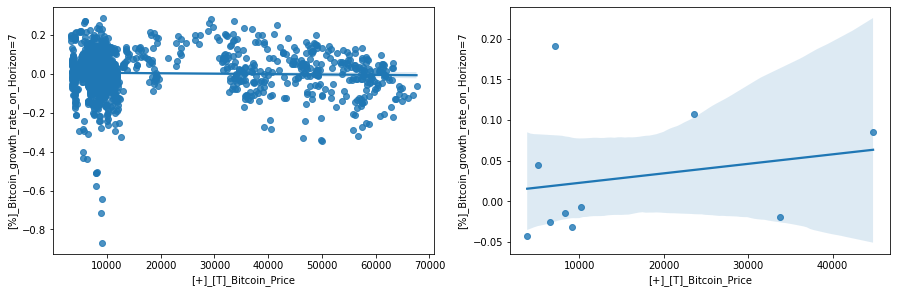

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.regplot(x='[+]_[T]_Bitcoin_Price', y='[%]_Bitcoin_growth_rate_on_Horizon=7', data=train_df, ci=95)
plt.subplot(2,2,2)
sns.regplot(x='[+]_[T]_Bitcoin_Price', y='[%]_Bitcoin_growth_rate_on_Horizon=7', data=train_df.sample(10, random_state=6), ci=95);

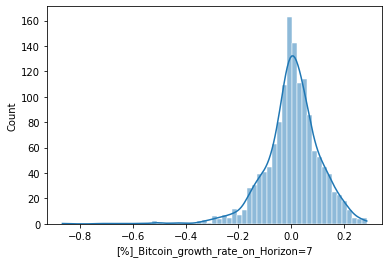

In [20]:
sns.histplot(train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'], kde=True, edgecolor='w');

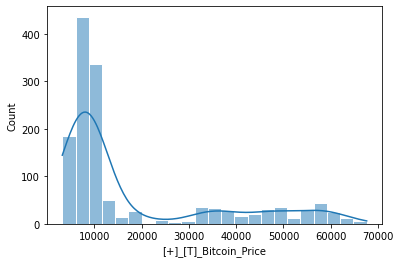

In [21]:
sns.histplot(train_df['[+]_[T]_Bitcoin_Price'], kde=True, edgecolor='w');

In [22]:
train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'].std()

0.10899637284583642

In [23]:
train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'].mean()

0.003258745217498152

## Exploration of ridge and lasso

In [10]:
#import X_train to tune the model
#intuition too much regularization

In [57]:
model_regression = LinearRegressionBaselineModel(alpha = 0.1 , l1_ratio = 0.001)

In [48]:
X_train, y_train, X_test, y_test = X_train_list[0], Y_train_list[0], X_test_list[0], Y_test_list[0]
X_train.shape

(263, 90, 32)

In [58]:
model_regression.fit(model_regression.preproc(X_test, X_train)[1], y_train)
None

In [59]:
model_regression.model.coef_

array([ 0.00620809,  0.00511102, -0.0031916 , -0.00492881,  0.00300117,
       -0.00228391, -0.00617027, -0.01824225,  0.00547382, -0.01840334,
       -0.01404511, -0.00477634,  0.00394955,  0.02841482,  0.00231628,
        0.02250352, -0.01774181, -0.00288451, -0.00161168, -0.01345576,
       -0.01471584, -0.00929029,  0.        , -0.01277325, -0.03046733,
        0.02004804, -0.0104408 ,  0.02872406, -0.01435881,  0.00957389,
       -0.01441603, -0.0134491 ])

## Analysing Coefs

### Elastic Net training

In [60]:
train(model_regression, train_df)

  9%|████▏                                       | 3/32 [00:00<00:02, 11.50it/s]

[ 0.00620809  0.00511102 -0.0031916  -0.00492881  0.00300117 -0.00228391
 -0.00617027 -0.01824225  0.00547382 -0.01840334 -0.01404511 -0.00477634
  0.00394955  0.02841482  0.00231628  0.02250352 -0.01774181 -0.00288451
 -0.00161168 -0.01345576 -0.01471584 -0.00929029  0.         -0.01277325
 -0.03046733  0.02004804 -0.0104408   0.02872406 -0.01435881  0.00957389
 -0.01441603 -0.0134491 ]
[ 0.00225349  0.00816153 -0.00111433 -0.00825532  0.00629075 -0.00352971
 -0.00988354 -0.01430053  0.00945679 -0.02049727 -0.01359918 -0.
 -0.00217022  0.03633914  0.0004537   0.01462165 -0.02684674 -0.00117029
 -0.00127408 -0.01332708 -0.01447823 -0.00446163  0.         -0.00980378
 -0.03222163  0.02521535 -0.01012939  0.02918904 -0.00393474  0.0119206
 -0.01491328 -0.01333025]
[-0.00106798  0.00931274  0.         -0.00964862  0.0061307  -0.00027975
 -0.00859984 -0.0144838   0.01808332 -0.02034126 -0.01275935  0.01542985
 -0.00690369  0.04314778 -0.          0.01188161 -0.02842259 -0.00378216
 -0.0008

 16%|██████▉                                     | 5/32 [00:00<00:02, 11.80it/s]

[ 0.00135714  0.00036241  0.00659309 -0.0006022   0.01475651 -0.00322098
 -0.01070667 -0.01334168  0.00252295 -0.02000344 -0.00741873  0.0136388
 -0.01023695  0.03727741  0.00594757  0.01819991 -0.00560857 -0.00295791
 -0.00551049 -0.00622864 -0.00640032  0.01265898  0.00209746 -0.00661549
 -0.01610582  0.02840378 -0.00398902  0.03779017  0.00509347  0.00673275
  0.00411017 -0.00623547]
[ 0.0085     -0.00502925  0.00949367  0.00493558  0.01732319 -0.00322457
 -0.01097015 -0.00759309  0.01151999 -0.02160632 -0.00408161  0.01995358
 -0.0101939   0.03468378  0.01377543  0.01807209 -0.         -0.00267979
 -0.00590697 -0.00013556  0.          0.0127212   0.00303308 -0.00503602
 -0.02179081  0.03000252 -0.          0.03708868  0.00494176 -0.03042257
  0.00982756 -0.00013699]
[ 0.01166686 -0.01007122  0.01488484  0.01009641  0.01200389 -0.00083078
 -0.00768185 -0.00929864  0.01543264 -0.01689604 -0.00055135  0.01809727
 -0.00575595  0.03042636  0.02178334  0.01772005 -0.00387956 -0.003457
 -

 28%|████████████▍                               | 9/32 [00:00<00:01, 12.71it/s]

[-0.00521349 -0.01379501  0.02448655  0.01295181  0.00881023  0.00303548
 -0.0063665  -0.          0.0085584  -0.0334845   0.01790901 -0.00807009
 -0.00372075  0.02532092  0.00495901  0.00499135 -0.         -0.00332563
 -0.03641214 -0.02070322 -0.01567238 -0.00563473  0.00115399 -0.01684587
 -0.01895905  0.01455506  0.00413431  0.0008951   0.00183489 -0.01915644
  0.04354458 -0.02071032]
[-0.0046914  -0.0036325   0.01219171  0.00310175  0.00362311  0.00548964
 -0.00477218 -0.00081125  0.00403964 -0.00294618  0.01868522 -0.00171246
 -0.00577256 -0.00640005 -0.02238151  0.00220251 -0.00205096 -0.0032831
 -0.02651476 -0.0145745  -0.00850058 -0.00671948 -0.00197569 -0.01712695
 -0.00748866  0.00797608 -0.00534273  0.00082298  0.00038492 -0.01376113
  0.02097055 -0.01458229]
[-0.01022841  0.          0.01190273 -0.00010257  0.          0.00380089
 -0.00238955 -0.          0.          0.0112498   0.031843   -0.02680687
 -0.00916336 -0.03330457 -0.01853766 -0.01029207 -0.00081748 -0.
 -0.0248

 34%|██████████████▊                            | 11/32 [00:00<00:01, 12.85it/s]

[-0.00415048  0.          0.00392562 -0.00032409  0.00040312 -0.
 -0.00089482 -0.00424962  0.00031537  0.00355363  0.02024647 -0.02565296
 -0.         -0.0356458  -0.0128453  -0.00293681 -0.00058101 -0.00050796
 -0.01643726 -0.01249739 -0.00778639 -0.00840665 -0.         -0.02073072
 -0.01872652  0.00261582 -0.00086365 -0.00438257 -0.01024356 -0.0127808
  0.01301265 -0.0125042 ]
[-0.00484787  0.00606819  0.00120077 -0.00625006  0.00289792 -0.00061098
 -0.0041036  -0.00219386 -0.00302848  0.00447554  0.02482501 -0.03144319
  0.         -0.03294256 -0.0132189   0.00150469 -0.         -0.
 -0.01634933 -0.01207182 -0.00720214 -0.0053081   0.         -0.01955083
 -0.01971913 -0.          0.00221509 -0.00876869 -0.00518216 -0.01374838
  0.0079355  -0.01207717]
[-0.00507548  0.00705882  0.00053048 -0.00728094  0.00045856 -0.00062218
 -0.00259369 -0.00010943 -0.00420697  0.00499713  0.01903254 -0.03244882
  0.00349847 -0.03019482 -0.01379076  0.00250772 -0.         -0.
 -0.01624379 -0.01225099

 47%|████████████████████▏                      | 15/32 [00:01<00:01, 13.47it/s]

[-0.00333986  0.00745824 -0.01121227 -0.00757574  0.00078053 -0.00814629
 -0.00227801 -0.00062595 -0.00822215  0.00523531  0.02445375 -0.03923376
  0.00526428 -0.0275498  -0.00652603  0.00630447 -0.00080153 -0.
 -0.01791736 -0.02091389 -0.01681892 -0.01324984 -0.         -0.02072121
 -0.01882807 -0.00156687 -0.00121727 -0.01097328 -0.00536835 -0.00514832
 -0.         -0.02091444]
[-0.00011099  0.00483912 -0.01657845 -0.00491953  0.         -0.00719846
 -0.00142827 -0.00220169 -0.00579584  0.00934837  0.0300923  -0.01853119
  0.00484321 -0.03221368 -0.0132839  -0.00495236 -0.         -0.
 -0.02125969 -0.02322191 -0.01375273 -0.01211363 -0.00052144 -0.01705215
 -0.01103016 -0.00297361  0.00260831 -0.00651366 -0.00520327  0.00231861
  0.         -0.02321961]
[-0.00122618  0.01036195 -0.04077546 -0.00985016 -0.00023487 -0.01474329
  0.         -0.01609672 -0.00733943  0.01523466  0.0110039  -0.03302531
  0.01100464 -0.01432001 -0.0119157  -0.          0.00849029 -0.
 -0.01444106 -0.0180230

 53%|██████████████████████▊                    | 17/32 [00:01<00:01, 13.58it/s]

[-0.00246465  0.00682218 -0.02106881 -0.00656218 -0.00308643 -0.01186377
  0.00022745 -0.01458102 -0.00653947  0.02824816  0.01831009 -0.02030221
  0.00933662 -0.01556572 -0.0166517   0.00176843  0.00730738  0.
 -0.0398038  -0.01822116 -0.01333532 -0.00780467  0.00188529 -0.02931725
 -0.01339745  0.00953111  0.00931985  0.00329639 -0.00804531 -0.01644296
  0.00284474 -0.01821876]
[ 0.00028859 -0.00088261 -0.02272709 -0.00610159  0.00221087 -0.00887081
 -0.00024701 -0.00925425 -0.00699677  0.04083694  0.01718245 -0.01336013
  0.00760949 -0.01629618 -0.01039788  0.00038143  0.00639445  0.00027843
 -0.06308113 -0.0178695  -0.01236899 -0.00323855  0.00290216 -0.02959483
 -0.00992217  0.0076901   0.00842794  0.00068189 -0.00829259 -0.01606083
 -0.         -0.0178718 ]
[-0.0018024   0.00853602 -0.00439818 -0.00815917 -0.00067918 -0.00736086
 -0.0002368  -0.01388363 -0.00956511  0.03233941  0.01678678 -0.012577
  0.00536243 -0.01395011 -0.0139726   0.00048356  0.00816879  0.00070338
 -0.06005

 66%|████████████████████████████▏              | 21/32 [00:01<00:00, 13.89it/s]

[ 0.00028477  0.00694495  0.00291168  0.         -0.00181631 -0.00275256
  0.         -0.01442444 -0.          0.01817716  0.02194151 -0.01130182
  0.00805746 -0.01546749 -0.01481333 -0.00485325  0.00887903  0.00087211
 -0.05690373 -0.01450958 -0.00977476 -0.00815899  0.00072293 -0.02820789
 -0.00903003  0.01585221  0.00746428  0.00019364 -0.01406179 -0.00266298
 -0.01623048 -0.0145065 ]
[-0.00089942  0.00173757  0.01095296 -0.00174311 -0.001972   -0.001644
  0.0025177  -0.01688801 -0.          0.02102181  0.01618456 -0.02403438
  0.00285756 -0.0156807  -0.01673452  0.          0.00574619  0.00023679
 -0.03807125 -0.01452014 -0.0110873  -0.00931349 -0.         -0.02228581
 -0.0098397   0.01866009  0.01266351  0.00509505 -0.01769486 -0.00734943
 -0.01416861 -0.01452271]
[-0.00490959  0.00200399  0.00237334 -0.00715542 -0.00268355 -0.00107499
  0.00283974 -0.015873   -0.00362923  0.02572704  0.01385139 -0.02621536
  0.0028183  -0.01289064 -0.01516021 -0.0026301   0.00846727  0.00079893
 

 72%|██████████████████████████████▉            | 23/32 [00:01<00:00, 13.48it/s]

[ 0.         -0.00067869  0.0057312   0.00376451 -0.00412103  0.00252797
  0.00527339 -0.01270806  0.00726391  0.03150538  0.00976217 -0.01480091
  0.00261821 -0.01563344 -0.01123563 -0.01127147  0.00965741  0.
 -0.02666722 -0.01494128 -0.01208768 -0.01387293  0.00131213 -0.02265169
 -0.02021345  0.02435922  0.01736272  0.00582534 -0.00675627 -0.00948767
 -0.01128647 -0.01494352]
[-0.00041274 -0.00759198  0.01476848  0.02046772 -0.00483006  0.00360608
  0.00745742 -0.01881166  0.02313695  0.03763833 -0.00167365  0.00644405
  0.00649312 -0.0061166  -0.01747531 -0.03100127  0.00997744  0.00044564
 -0.00848651 -0.01076128 -0.01352868 -0.02324044  0.00513814 -0.02460815
 -0.02938026  0.03582111  0.02892759  0.02036897  0.00154052 -0.01338891
 -0.00451897 -0.01076611]
[ 0.00240654 -0.01447138  0.01656075  0.00377833  0.         -0.0027881
  0.00826037 -0.00545813  0.01839032  0.00508608 -0.00891335  0.00062809
 -0.00394526  0.00285449 -0.00873048 -0.00171439  0.00226976  0.00442691
  0.0077

 84%|████████████████████████████████████▎      | 27/32 [00:02<00:00, 13.83it/s]

[-0.00154394 -0.00801962  0.01541868  0.01080451 -0.00455813 -0.00425624
  0.00926474 -0.00808953  0.02456149  0.01580801 -0.00689087 -0.00488503
 -0.00489627  0.00080917 -0.0175312   0.01275112  0.00218072 -0.00557307
 -0.          0.01181099 -0.00362822 -0.0073535  -0.00396595  0.00133483
 -0.0072328   0.02099741  0.01242096  0.00212745  0.01642837 -0.00096287
 -0.00141029 -0.00433577]
[ 0.0011166  -0.01531933  0.01695561  0.01519729 -0.01235507 -0.00396985
  0.00274211 -0.00640722  0.02011381  0.00700682 -0.01084019 -0.01924554
 -0.00841343  0.00593454 -0.02294603  0.01109049  0.         -0.01301604
  0.00564208  0.01189452 -0.00896944 -0.00920967 -0.01182094  0.00761521
 -0.01115981  0.02952617  0.01689127  0.00599748  0.00364466 -0.00884888
  0.00464559 -0.00518127]
[-0.00033363 -0.01581771  0.00843501  0.01554117 -0.01476825 -0.00254687
  0.00150747 -0.00758602  0.01041279  0.00904786 -0.00760542 -0.01567469
 -0.00412257  0.0042279  -0.03024915  0.01269176  0.         -0.01314543

 91%|██████████████████████████████████████▉    | 29/32 [00:02<00:00, 14.01it/s]

[-0.00206231 -0.01764904  0.0005996   0.01725959 -0.01382851 -0.00261902
  0.00230546 -0.00739732  0.00618886  0.0192488  -0.00352086 -0.01046386
 -0.00269989  0.00130588 -0.02785128  0.00978105  0.         -0.0152355
 -0.00853314  0.01377354 -0.01111643 -0.01085712 -0.0059047   0.
 -0.00737142 -0.00122993 -0.         -0.          0.01916081 -0.00706821
  0.01570142 -0.01684426]
[-0.0116114  -0.00556018 -0.02058976  0.00560401 -0.0282936  -0.00954699
  0.00933343 -0.00399467 -0.003074    0.02624943  0.00076702 -0.00319786
 -0.01203542 -0.00157379 -0.02543821 -0.00433763  0.00274665 -0.01066032
 -0.01861714  0.01484652  0.         -0.00779505 -0.00177735 -0.
  0.00044828 -0.01523893 -0.01465551  0.00669819  0.02044245 -0.01067747
  0.02922518 -0.01475463]
[-0.0185071   0.00278735 -0.02153394 -0.0029008  -0.0280992  -0.00672083
  0.00938323 -0.00208226 -0.00797237  0.01535931  0.00121166 -0.00640683
 -0.01248641 -0.         -0.00430747  0.00273431 -0.         -0.01026861
 -0.01581701  0.

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 13.12it/s]

[-0.01025923  0.0105261  -0.02520439 -0.01063119 -0.0197226  -0.00708387
  0.00693331 -0.0018831  -0.01269512  0.0145597   0.00611825 -0.00538873
 -0.01512784 -0.00396861  0.00395881  0.00272005 -0.00371437 -0.00864099
 -0.01748351 -0.00231847 -0.00518601 -0.01398461 -0.00802169 -0.01409617
 -0.00335219 -0.01740109 -0.0169379   0.01299763  0.01168836 -0.024249
  0.01761167 -0.01382745]
[-0.02484581 -0.         -0.01722614 -0.         -0.00646613 -0.01981137
 -0.00242079 -0.00422284 -0.01348827  0.01144002  0.00532304 -0.0129991
 -0.01551387 -0.01080718  0.00783025 -0.0183517  -0.00265678 -0.00311914
 -0.01834758 -0.01590381 -0.0113686  -0.01573938 -0.00791318 -0.01090791
 -0.00619927 -0.01353654 -0.01563728  0.0042912   0.01308569 -0.02699336
  0.01288021 -0.02053929]
Training done


([854.24552,
  622.42861,
  493.03903,
  216.84037,
  476.10354,
  1167.71516,
  340.3274,
  127.79453,
  155.2315,
  200.70063,
  207.71237,
  200.98841,
  249.87299,
  120.10755,
  466.9585,
  308.81563,
  1708.94191,
  510.69796,
  420.72263,
  116.88678,
  259.62061,
  583.59981,
  194.02654,
  372.60938,
  247.062,
  491.82926,
  545.84708,
  330.23043,
  277.75573,
  261.37473,
  373.2109,
  194.1036],
 409.29378)

### VIF index

In [ ]:
train_df_nodates = train_df.copy()#.drop(columns = 'date')#.drop(columns = bucket_list)

In [ ]:
train_df_nodates_scaled = train_df_nodates.copy()

for feature in train_df_nodates_scaled.columns:
    mu = train_df_nodates[feature].mean()
    sigma = train_df_nodates[feature].std()
    train_df_nodates_scaled[feature] = train_df_nodates_scaled[feature].apply(lambda x: (x-mu)/sigma)

In [ ]:
df = pd.DataFrame()

df["features"] = train_df_nodates_scaled.columns

df["vif_index"] = [vif(train_df_nodates_scaled.values, i) for i in range(train_df_nodates_scaled.shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2).reset_index(drop = True)

### Coef matrix

In [ ]:
coeff_matrix = pd.DataFrame(zip(train_df.columns,model_regression.model.coef_))
coeff_matrix = coeff_matrix.rename(columns={0: "features", 1: "coeff"})
coeff_matrix_absolute = coeff_matrix.copy()
coeff_matrix_absolute['coeff abs'] = coeff_matrix['coeff'].apply(abs)
coeff_matrix_absolute = coeff_matrix_absolute.drop(columns = 'coeff')
coeff_matrix_absolute.sort_values(by = 'coeff abs', ascending = False).reset_index(drop = True)

In [ ]:
plt.figure(figsize = (22,20))
sns.heatmap(round(train_df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [ ]:
train_df.corr().style.background_gradient(cmap='coolwarm')

## Defining Dummy model as baseline

In [ ]:
# Instanciate model
dummy_model = DummyModel()
# Train and Fit data using the crossval
train(dummy_model,train_df)

## Elastic Net Tuning

In [ ]:
# Instanciate Grid Search
for counter in range(30):
    alpha = 50 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    train(model,train_df)

## RNN tuning

In [ ]:
# Instanciate Grid Search
for counter in range(5):
    l1 = random() / 10
    l2 = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1, L2 = l2)
    # Train and Fit data using the crossval
    train(model,train_df)
    None

## Exporting and viewing results

In [ ]:
df_result = read_result()
df_result.sort_values(by="mean_score")

## Notes

In [9]:
# take mean on the week on linear regression and inspect the weights
# create a btc trajectory on linear trend +2% (test unitaire) => check outcome of strategies in a basic situation
# y_diff to try to improve MAPE
# Check colinearity on coefficients => heatmap ?
# RNN, can try with less features from 2015 if we lack of simples (263 sized sequences, might not be enough)
# l1 is a feature selector that can help tune the RNN
#Feature importance
#if you don't have enough variance, you can leave them out
#Vif analysis on X
#checking the y permutation importance (suffling and checking impact on R2)
#Reco => vif on features & lasso importance
#shuffle on each folds axis = 0 np.array.shuffle()